In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import sqlalchemy as db
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

In [2]:
load_dotenv()

# config and credentials
server = os.getenv('server')
database = os.getenv('database')
username = os.getenv('username')
password = os.getenv('password')

# connection
engine = db.create_engine(
    'mssql://{}:{}@{}/{}?driver=ODBC+Driver+18+for+SQL+Server'.format(
        username, password, server, database
    )
)

# establish connection
connection = engine.connect()

In [3]:
query = 'SELECT * FROM BondReturns'

df = pd.read_sql(query, connection)

In [4]:
df.head()

,LtTrdExctnDt,CusipId,RptdPr,LagRptdPr,Coupon,InterestFrequency,T,D,AccruedInterest,LagAccruedInterest,R
0,2002-07-26,000325AA8,100.625,NaN,9.0,2,180,167,1.043750,NaN,NaN
1,2002-08-30,000336AE7,97.693,NaN,7.0,2,180,93,0.452083,NaN,NaN
2,2002-09-30,000336AE7,93.155,97.693,7.0,2,180,123,0.597917,0.452083,0.026571
3,2002-10-31,000336AE7,96.000,93.155,7.0,2,180,153,0.743750,0.597917,0.106566
4,2002-11-27,000336AE7,103.431,96.000,7.0,2,180,0,0.000000,0.743750,0.141479


In [5]:
df['R'] = df['R'].fillna(0)

In [6]:
df.head()

,LtTrdExctnDt,CusipId,RptdPr,LagRptdPr,Coupon,InterestFrequency,T,D,AccruedInterest,LagAccruedInterest,R
0,2002-07-26,000325AA8,100.625,NaN,9.0,2,180,167,1.043750,NaN,0.000000
1,2002-08-30,000336AE7,97.693,NaN,7.0,2,180,93,0.452083,NaN,0.000000
2,2002-09-30,000336AE7,93.155,97.693,7.0,2,180,123,0.597917,0.452083,0.026571
3,2002-10-31,000336AE7,96.000,93.155,7.0,2,180,153,0.743750,0.597917,0.106566
4,2002-11-27,000336AE7,103.431,96.000,7.0,2,180,0,0.000000,0.743750,0.141479


In [7]:
df['logR'] = np.log(1 + df['R'])

In [8]:
df.head()

,LtTrdExctnDt,CusipId,RptdPr,LagRptdPr,Coupon,InterestFrequency,T,D,AccruedInterest,LagAccruedInterest,R,logR
0,2002-07-26,000325AA8,100.625,NaN,9.0,2,180,167,1.043750,NaN,0.000000,0.000000
1,2002-08-30,000336AE7,97.693,NaN,7.0,2,180,93,0.452083,NaN,0.000000,0.000000
2,2002-09-30,000336AE7,93.155,97.693,7.0,2,180,123,0.597917,0.452083,0.026571,0.026224
3,2002-10-31,000336AE7,96.000,93.155,7.0,2,180,153,0.743750,0.597917,0.106566,0.101261
4,2002-11-27,000336AE7,103.431,96.000,7.0,2,180,0,0.000000,0.743750,0.141479,0.132325


In [9]:
J = 6 # formation period

df_ = df[
    ['CusipId', 'LtTrdExctnDt', 'R', 'logR', ]
].sort_values(['CusipId', 'LtTrdExctnDt']).set_index('LtTrdExctnDt')

cumr = df_.groupby(['CusipId'])['logR'].rolling(J).sum().reset_index()
cumr = cumr.rename(columns={'logR': 'SumLogR'})
cumr['CumRet']=np.exp(cumr['SumLogR'])-1

In [10]:
cumr.tail(10)

,CusipId,LtTrdExctnDt,SumLogR,CumRet
1072681,989822AA9,2022-05-31,0.326525,0.386143
1072682,989822AA9,2022-06-30,0.330061,0.391053
1072683,989822AA9,2022-07-29,0.339204,0.403829
1072684,989822AA9,2022-08-31,0.343827,0.410334
1072685,989822AA9,2022-09-30,0.354162,0.424986
1072686,G65422AA8,2012-06-29,NaN,NaN
1072687,G65422AA8,2012-07-27,NaN,NaN
1072688,G65422AA8,2012-08-30,NaN,NaN
1072689,G65422AA8,2012-09-28,NaN,NaN
1072690,G65422AA8,2013-01-29,NaN,NaN


In [11]:
r = 10 # momentum ranking

cumr = cumr.dropna(axis=0, subset=['CumRet'])

cumr['MomR'] = cumr.groupby('LtTrdExctnDt')['CumRet'].transform(lambda x: pd.qcut(x, r, labels=False))
cumr['MomR'] = 1 + cumr['MomR'].astype(int)

In [12]:
cumr.head()

,CusipId,LtTrdExctnDt,SumLogR,CumRet,MomR
6,000336AE7,2003-03-31,0.252935,0.287800,1
7,000336AE7,2003-04-29,0.363418,0.438236,3
8,000336AE7,2003-07-29,0.475227,0.608379,8
9,000336AE7,2003-08-26,0.429619,0.536672,7
10,000336AE7,2003-10-27,0.379051,0.460897,5


In [13]:
cumr['CumRet'].max()

6405570785.673553

In [14]:
cumr.groupby('MomR')['CumRet'].mean()

MomR
1          0.133641
2          0.213151
3          0.252937
4          0.285811
5          0.316493
6          0.347424
7          0.382923
8          0.427211
9          0.496935
10    165774.722662
Name: CumRet, dtype: float64

In [15]:
K = 6 # Holding Period Length: K can be between 3 to 12 months

cumr['form_date'] = cumr['LtTrdExctnDt']
cumr['medate'] = cumr['LtTrdExctnDt'] + MonthEnd(0)
cumr['hdate1'] = cumr['medate'] + MonthBegin(1)
cumr['hdate2'] = cumr['medate'] + MonthEnd(K)
cumr = cumr[['CusipId', 'form_date','MomR','hdate1','hdate2']]

In [16]:
cumr.head()

,CusipId,form_date,MomR,hdate1,hdate2
6,000336AE7,2003-03-31,1,2003-04-01,2003-09-30
7,000336AE7,2003-04-29,3,2003-05-01,2003-10-31
8,000336AE7,2003-07-29,8,2003-08-01,2004-01-31
9,000336AE7,2003-08-26,7,2003-09-01,2004-02-29
10,000336AE7,2003-10-27,5,2003-11-01,2004-04-30


In [17]:
port = pd.merge(df[['CusipId', 'LtTrdExctnDt', 'R']], cumr, on=['CusipId'], how='inner')
port = port[(port['hdate1']<=port['LtTrdExctnDt']) & (port['LtTrdExctnDt']<=port['hdate2'])]
port = port[['CusipId','form_date', 'MomR', 'hdate1','hdate2', 'LtTrdExctnDt', 'R']]

In [18]:
port.head()

,CusipId,form_date,MomR,hdate1,hdate2,LtTrdExctnDt,R
150,000336AE7,2003-03-31,1,2003-04-01,2003-09-30,2003-04-29,0.116817
175,000336AE7,2003-03-31,1,2003-04-01,2003-09-30,2003-07-29,0.148014
176,000336AE7,2003-04-29,3,2003-05-01,2003-10-31,2003-07-29,0.148014
200,000336AE7,2003-03-31,1,2003-04-01,2003-09-30,2003-08-26,0.057231
201,000336AE7,2003-04-29,3,2003-05-01,2003-10-31,2003-08-26,0.057231


In [19]:
port['LtTrdExctnDt'] = pd.to_datetime(port['LtTrdExctnDt'])

In [20]:
port.head()

,CusipId,form_date,MomR,hdate1,hdate2,LtTrdExctnDt,R
150,000336AE7,2003-03-31,1,2003-04-01,2003-09-30,2003-04-29,0.116817
175,000336AE7,2003-03-31,1,2003-04-01,2003-09-30,2003-07-29,0.148014
176,000336AE7,2003-04-29,3,2003-05-01,2003-10-31,2003-07-29,0.148014
200,000336AE7,2003-03-31,1,2003-04-01,2003-09-30,2003-08-26,0.057231
201,000336AE7,2003-04-29,3,2003-05-01,2003-10-31,2003-08-26,0.057231


In [21]:
cumr_port = port.groupby(['LtTrdExctnDt','MomR', 'form_date'])['R'].mean().reset_index()
start_yr = cumr_port['LtTrdExctnDt'].dt.year.min()+2
cumr_port = cumr_port.loc[cumr_port.LtTrdExctnDt.dt.year>=start_yr]
cumr_port = cumr_port.sort_values(by=['LtTrdExctnDt','MomR'])

In [22]:
cumr_port.head()

,LtTrdExctnDt,MomR,form_date,R
20630,2005-01-26,1,2004-07-26,0.028767
20631,2005-01-26,1,2004-07-27,0.027751
20632,2005-01-26,1,2004-07-28,0.026530
20633,2005-01-26,1,2004-07-29,0.037128
20634,2005-01-26,1,2004-07-30,0.033523


In [23]:
ewret = cumr_port.groupby(['LtTrdExctnDt','MomR'])['R'].mean().reset_index()
ewstd = cumr_port.groupby(['LtTrdExctnDt','MomR'])['R'].std().reset_index()

ewret = ewret.rename(columns={'R':'ewret'})
ewstd = ewstd.rename(columns={'R':'ewretstd'})

ewretdf = pd.merge(ewret, ewstd, on=['LtTrdExctnDt','MomR'], how='inner')
ewretdf = ewretdf.sort_values(by=['MomR', 'LtTrdExctnDt'])

In [24]:
ewretdf.head()

,LtTrdExctnDt,MomR,ewret,ewretstd
0,2005-01-26,1,0.039335,0.010878
10,2005-01-27,1,0.035584,0.009371
20,2005-01-28,1,0.038955,0.011158
30,2005-01-31,1,0.039507,0.005900
40,2005-02-23,1,0.036905,0.009050


In [25]:
ewretdf.groupby(['MomR'])['ewret'].describe()[['count','mean', 'std']].reset_index()

,MomR,count,mean,std
0,1,882.0,0.057257,0.121151
1,2,882.0,0.044253,0.030634
2,3,882.0,0.047285,0.034818
3,4,882.0,0.050075,0.031315
4,5,882.0,0.051395,0.022454
5,6,882.0,0.053837,0.021621
6,7,882.0,0.056773,0.022198
7,8,882.0,0.060478,0.025858
8,9,882.0,0.066040,0.024036
9,10,882.0,0.218568,0.367827


In [26]:
ewret_t = ewretdf.pivot(index='LtTrdExctnDt', columns='MomR', values='ewret') 

# Add prefix port in front of each column 
ewret_t = ewret_t.add_prefix('port') 
ewret_t = ewret_t.rename(columns={'port1':'losers', 'port10':'winners'}) 
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers

In [27]:
ewret_t.head()

MomR,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
LtTrdExctnDt,,,,,,,,,,,
2005-01-26,0.039335,0.050552,0.060768,0.066792,0.064841,0.066440,0.069844,0.071261,0.075761,0.140218,0.100882
2005-01-27,0.035584,0.053167,0.057404,0.062420,0.066411,0.067453,0.074807,0.072546,0.075243,0.554197,0.518614
2005-01-28,0.038955,0.057748,0.061284,0.064436,0.070284,0.071567,0.073358,0.073498,0.065049,0.113888,0.074933
2005-01-31,0.039507,0.054248,0.060850,0.062558,0.066870,0.069461,0.071090,0.074826,0.079188,0.177972,0.138465
2005-02-23,0.036905,0.051707,0.058098,0.060292,0.062469,0.061286,0.060298,0.066216,0.072765,0.170242,0.133337


In [28]:
ewret_t['cumret_winners'] = (1 + ewret_t.winners).cumprod()-1 
ewret_t['cumret_losers'] = (1 + ewret_t.losers).cumprod()-1
ewret_t['cumret_long_short'] = (1 + ewret_t.long_short).cumprod()-1

In [29]:
mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame() 
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index() 
mom_mean

,MomR,mean
0,winners,0.218568
1,losers,0.057257
2,long_short,0.161311


In [30]:
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'],0.0)).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'],0.0)).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'],0.0)).to_frame().T

t_losers['MomR']='losers' 
t_winners['MomR']='winners' 
t_long_short['MomR']='long_short'

In [31]:
t_output =pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p and format output 
mom_output = pd.merge(mom_mean, t_output, on=['MomR'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format) 
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format) 
mom_output['p-value'] = mom_output['p-value'].map('{:.2f}'.format) 

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          MomR    mean t-stat p-value
0     winners  21.86%  17.65    0.00
1      losers   5.73%  14.04    0.00
2  long_short  16.13%  12.90    0.00


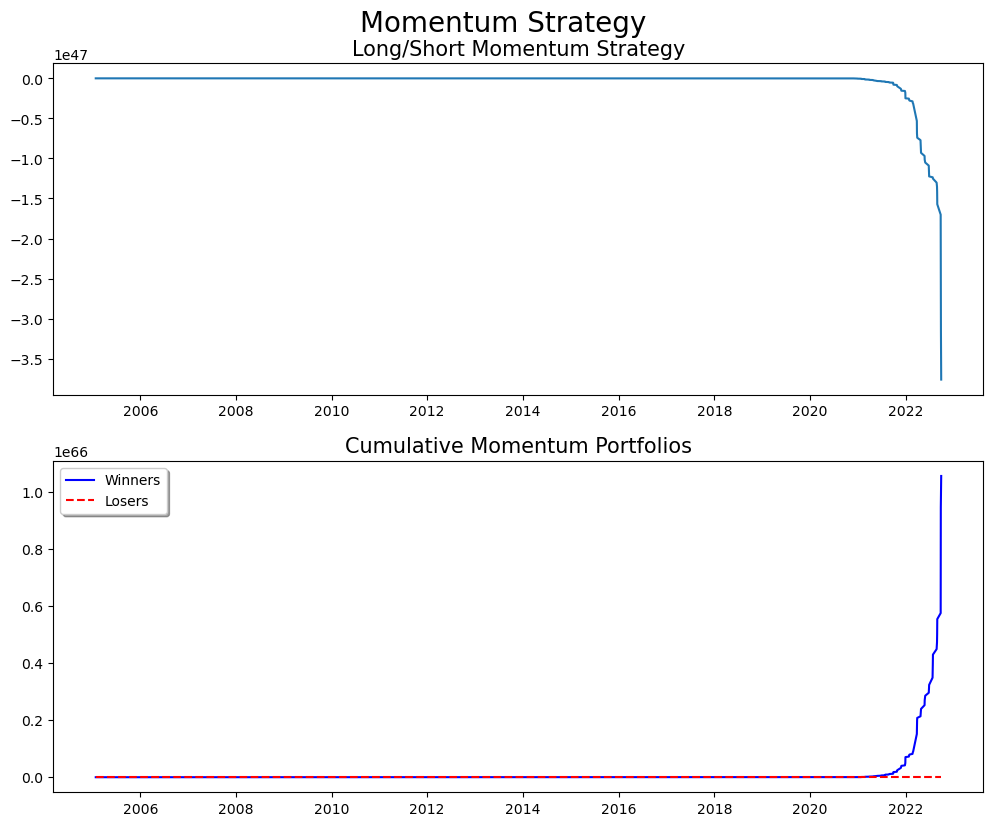

In [32]:
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 

ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(ewret_t['cumret_long_short']) 

ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True) 

plt.subplots_adjust(top=0.92, hspace=0.2)